In [1]:
import datetime as dt
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import signal
import scipy.stats as scs
from statsmodels.tsa.statespace.sarimax import SARIMAX
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
from pymongo import MongoClient
from pprint import pprint
import ast
%matplotlib inline

/Users/djo/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
egv_high = 200
egv_low = 80

In [3]:
client = MongoClient()
db = client.future_sense
collection = db.docs

In [4]:
collection.find_one()

{u'_id': ObjectId('59ea1ec3fd1d724edf839639'),
 u'displayTime': u'2015-09-21T13:30:00',
 u'rate': u'mg/dL/min',
 u'recordType': u'egv',
 u'status': u'null',
 u'systemTime': u'2015-09-21T21:30:00',
 u'trend': u'flat',
 u'trendRate': -0.7,
 u'units': u'mg/dL',
 u'user': u'sandbox3',
 u'value': 139}

In [5]:
collection.find_one({'user': 'sandbox1', 'recordType': 'egv'})

{u'_id': ObjectId('59ea1ec3fd1d724edf839872'),
 u'displayTime': u'2015-09-21T13:30:00',
 u'rate': u'mg/dL/min',
 u'recordType': u'egv',
 u'status': u'null',
 u'systemTime': u'2015-09-21T21:30:00',
 u'trend': u'fortyFiveDown',
 u'trendRate': -1.2,
 u'units': u'mg/dL',
 u'user': u'sandbox1',
 u'value': 79}

In [6]:
collection.find_one({'user': 'sandbox1', 'recordType': 'event'})

{u'_id': ObjectId('59ea2d01fd1d724edf8961cf'),
 u'displayTime': u'2015-09-21T11:48:00',
 u'eventSubType': u'light',
 u'eventType': u'exercise',
 u'recordType': u'event',
 u'systemTime': u'2015-09-21T19:48:00',
 u'unit': u'minutes',
 u'user': u'sandbox1',
 u'value': 23}

In [7]:
collection.find_one({'user': 'sandbox1', 'recordType': 'calibration'})

{u'_id': ObjectId('59ea2cddfd1d724edf895a5b'),
 u'displayTime': u'2015-09-20T07:58:53',
 u'recordType': u'calibration',
 u'systemTime': u'2015-09-20T15:58:53',
 u'unit': u'mg/dL',
 u'user': u'sandbox1',
 u'value': 90}

In [8]:
def load_model_data(user):
    x = []
    for record in collection.find({'user': user}):
        x.append(record)
    df = pd.DataFrame(x)
    df = df.set_index(pd.DatetimeIndex(df.displayTime))
    df = df.drop(['systemTime', '_id'], axis=1)
    df = df.sort_index(ascending=True)
    
    df.displayTime = pd.to_datetime(df.displayTime)
    
    df.recordType = df.recordType.astype('category')
    df.eventType = df.eventType.astype('category')
    df.eventSubType = df.eventSubType.astype('category')
    df.rate = df.rate.astype('category')
    
    df.loc[(df['status']=='low'), 'status'] = 'lowlow'
    df.loc[(df['status']=='high'), 'status'] = 'highhigh'
    df.loc[(df['recordType']=='egv') & (df['value'] > egv_high), 'status'] = 'high'
    df.loc[(df['recordType']=='egv') & (df['value'] < egv_low), 'status'] = 'low'
    df.loc[(df['status']=='null'), 'status'] = 'normal'
    df.status = df.status.astype('category')
    
    df['dangerZone'] = [x!='normal' for x in df.loc[:, 'status']] 
    
    df.trend = df.trend.astype('category')
    df.trendRate = df.trendRate.astype('float')
    df.loc[(df['unit']=='null'), 'unit'] = float('nan')
    df.unit = df.unit.astype('category')
    
    
    df.units = df.units.astype('category')
    df.user = df.user.astype('category')
    df['value'] =  pd.to_numeric(df['value'], errors='coerce') 

    return df

In [9]:
df = load_model_data('sandbox1')

In [10]:
df['displayTime'][100]

Timestamp('2015-09-20 00:15:00')

In [11]:
s = df['displayTime'][100] - df['displayTime'][40]
s.seconds

17700

In [12]:
(df['displayTime'][100] - df['displayTime'][40]).seconds

17700

In [13]:
df.tail()

,displayTime,eventSubType,eventType,rate,recordType,status,trend,trendRate,unit,units,user,value,dangerZone
displayTime,,,,,,,,,,,,,
2015-12-21 15:35:00,2015-12-21 15:35:00,NaN,NaN,mg/dL/min,egv,normal,flat,-0.4,NaN,mg/dL,sandbox1,149.0,False
2015-12-21 15:40:00,2015-12-21 15:40:00,NaN,NaN,mg/dL/min,egv,normal,flat,-0.2,NaN,mg/dL,sandbox1,149.0,False
2015-12-21 15:45:00,2015-12-21 15:45:00,NaN,NaN,mg/dL/min,egv,normal,flat,-0.1,NaN,mg/dL,sandbox1,148.0,False
2015-12-21 15:50:00,2015-12-21 15:50:00,NaN,NaN,mg/dL/min,egv,normal,flat,-0.1,NaN,mg/dL,sandbox1,148.0,False
2015-12-21 15:55:00,2015-12-21 15:55:00,NaN,NaN,mg/dL/min,egv,normal,flat,-0.2,NaN,mg/dL,sandbox1,146.0,False


In [18]:
df['status'].unique()

[normal, NaN, low, high]
Categories (3, object): [normal, low, high]

In [19]:
df.loc[df['status'].isnull(), 'recordType'].unique()

[calibration, event]
Categories (2, object): [calibration, event]

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27585 entries, 2015-09-19 16:00:00 to 2015-12-21 15:55:00
Data columns (total 15 columns):
displayTime             27585 non-null datetime64[ns]
eventSubType            615 non-null category
eventType               615 non-null category
rate                    26784 non-null category
recordType              27585 non-null category
status                  26784 non-null category
trend                   26784 non-null category
trendRate               26784 non-null float64
unit                    778 non-null category
units                   26784 non-null category
user                    27585 non-null category
value                   27562 non-null float64
dangerZone              27585 non-null bool
last_calib_timedelta    27537 non-null float64
last_calib_accuracy     27537 non-null float64
dtypes: bool(1), category(9), datetime64[ns](1), float64(4)
memory usage: 2.8 MB


In [21]:
df3 = df.copy()

In [22]:
def __load_user_data_2(user):
    x = []
    for record in collection.find({'user': user}):
        x.append(record)
    df = pd.DataFrame(x)
    df = df.set_index(pd.DatetimeIndex(df.displayTime))
    df = df.drop(['displayTime', 'systemTime', '_id'], axis=1)
    df = df.sort_index(ascending=True)
    
    df.user = df.user.astype('category')
    df.recordType = df.recordType.astype('category')
    df.rate = df.rate.astype('category')
    
    # Status to low if below bounds, high if above bounds, 
    # lowlow if undetectably low, highhigh if undetectably high,
    # otherwise NaN
    df.loc[(df['status']=='low'), 'status'] = 'lowlow'
    df.loc[(df['status']=='high'), 'status'] = 'highhigh'
    df.loc[(df['recordType']=='egv') & (df['value'] > egv_high), 'status'] = 'high'
    df.loc[(df['recordType']=='egv') & (df['value'] < egv_low), 'status'] = 'low'
    df.loc[(df['status']=='null'), 'status'] = float('nan')
    df.status = df.status.astype('category')
    
    # Create target label
    df['dangerZone'] = [type(x)==str for x in df.loc[:, 'status']] 
    
    df.trend = df.trend.astype('category')
    df.trendRate = df.trendRate.astype('float')
    df.loc[(df['unit']=='null'), 'unit'] = float('nan')
    
    # Split various Value types into unique features
    df['value'] =  pd.to_numeric(df['value'], errors='coerce') 
    df['egv_value'] = df.loc[df['recordType']=='egv', 'value']
    df['calibration_value'] = df.loc[df['recordType']=='calibration', 'value']
    df['insulin_value'] = df.loc[df['eventType']=='insulin', 'value']
    df['carbs_value'] = df.loc[df['eventType']=='carbs', 'value']
    df['light_exercise_value'] = df.loc[df['eventSubType']=='light', 'value']
    df['medium_exercise_value'] = df.loc[df['eventSubType']=='medium', 'value']
    df['heavy_exercise_value'] = df.loc[df['eventSubType']=='heavy', 'value']
    df['high_symptoms'] = [x=='highSymptoms' for x in df.loc[:, 'eventSubType']]
    df['low_symptoms'] = [x=='lowSymptoms' for x in df.loc[:, 'eventSubType']]
    df['stress'] = [x=='stress' for x in df.loc[:, 'eventSubType']]

    # Combine 'unit' and 'units' columns into single column
    df.loc[df['units'].isnull(), 'units'] = df.loc[df['units'].isnull(), 'unit']
    df.units = df.units.astype('category')

    df.drop(['eventSubType', 'eventType', 'unit', 'value'], axis=1, inplace=True)
    
    return df

In [24]:
df3.columns

Index([         u'displayTime',         u'eventSubType',
                  u'eventType',                 u'rate',
                 u'recordType',               u'status',
                      u'trend',            u'trendRate',
                       u'unit',                u'units',
                       u'user',                u'value',
                 u'dangerZone', u'last_calib_timedelta',
        u'last_calib_accuracy'],
      dtype='object')

In [25]:
df3.drop(['eventSubType', 'eventType', 'unit'], axis=1, inplace=True)

In [26]:
df3.columns

Index([         u'displayTime',                 u'rate',
                 u'recordType',               u'status',
                      u'trend',            u'trendRate',
                      u'units',                 u'user',
                      u'value',           u'dangerZone',
       u'last_calib_timedelta',  u'last_calib_accuracy'],
      dtype='object')

In [27]:
df3.drop('value', axis=1, inplace=True)

In [28]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27585 entries, 2015-09-19 16:00:00 to 2015-12-21 15:55:00
Data columns (total 11 columns):
displayTime             27585 non-null datetime64[ns]
rate                    26784 non-null category
recordType              27585 non-null category
status                  26784 non-null category
trend                   26784 non-null category
trendRate               26784 non-null float64
units                   26784 non-null category
user                    27585 non-null category
dangerZone              27585 non-null bool
last_calib_timedelta    27537 non-null float64
last_calib_accuracy     27537 non-null float64
dtypes: bool(1), category(6), datetime64[ns](1), float64(3)
memory usage: 1.2 MB


In [31]:
df3['status'].unique()

[normal, NaN, low, high]
Categories (3, object): [normal, low, high]

In [32]:
df3.columns

Index([         u'displayTime',                 u'rate',
                 u'recordType',               u'status',
                      u'trend',            u'trendRate',
                      u'units',                 u'user',
                 u'dangerZone', u'last_calib_timedelta',
        u'last_calib_accuracy'],
      dtype='object')

In [34]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27585 entries, 2015-09-19 16:00:00 to 2015-12-21 15:55:00
Data columns (total 11 columns):
displayTime             27585 non-null datetime64[ns]
rate                    26784 non-null category
recordType              27585 non-null category
status                  26784 non-null category
trend                   26784 non-null category
trendRate               26784 non-null float64
units                   26784 non-null category
user                    27585 non-null category
dangerZone              27585 non-null bool
last_calib_timedelta    27537 non-null float64
last_calib_accuracy     27537 non-null float64
dtypes: bool(1), category(6), datetime64[ns](1), float64(3)
memory usage: 2.5 MB


In [35]:
def load_user_data(user):
    x = []
    for record in collection.find({'user': user}):
        x.append(record)
    df = pd.DataFrame(x)
    df = df.set_index(pd.DatetimeIndex(df.displayTime))
    df.displayTime = pd.to_datetime(df.displayTime)
    df = df.sort_index(ascending=True)
    
    # Status to low if below bounds, high if above bounds, 
    # lowlow if undetectably low, highhigh if undetectably high,
    # otherwise normal
    df.loc[(df['status']=='low'), 'status'] = 'lowlow'
    df.loc[(df['status']=='high'), 'status'] = 'highhigh'
    df.loc[(df['recordType']=='egv') & (df['value'] > egv_high), 'status'] = 'high'
    df.loc[(df['recordType']=='egv') & (df['value'] < egv_low), 'status'] = 'low'
    df.loc[(df['status']!='lowlow') & (df['status']!='highhigh') & (df['status']!='low') & (df['status']!='high'), 'status'] = 'normal'
    df.status = df.status.astype('category')
    
    # Create target label
    df['dangerZone'] = [x!='normal' for x in df.loc[:, 'status']] 
    
    # calculate timedelta since most recent event of each type, plus other metrics based on event
    calibtimedelts = []
    accs = []
    insulintimedelts = []
    insulinamts = []
    carbstimedelts = []
    carbsamts = []
    exercisetimedelts = []
    exerciseamts = []
    exercisetypes = []
    stress = []
    highSymptoms = []
    lowSymptoms = []
    illness = []
    alcohol = []
    for ts in df['displayTime']:
        last_cal = df.loc[(df['recordType']=='calibration') & (df['displayTime'] <= ts), 'displayTime'].max()
        calibtimedelts.append((ts - last_cal).seconds)
        last_ins = df.loc[(df['eventType']=='insulin') & (df['displayTime'] <= ts), 'displayTime'].max()
        insulintimedelts.append((ts - last_ins).seconds)
        last_carbs = df.loc[(df['eventType']=='carbs') & (df['displayTime'] <= ts), 'displayTime'].max()
        carbstimedelts.append((ts - last_carbs).seconds)
        last_ex = df.loc[(df['eventType']=='exercise') & (df['displayTime'] <= ts), 'displayTime'].max()
        exercisetimedelts.append((ts - last_ex).seconds)
        last_stress = df.loc[(df['eventSubType']=='stress') & (df['displayTime'] <= ts), 'displayTime'].max()
        stress.append((ts - last_stress).seconds)
        last_high = df.loc[(df['eventSubType']=='highSymptoms') & (df['displayTime'] <= ts), 'displayTime'].max()
        highSymptoms.append((ts - last_high).seconds)
        last_low = df.loc[(df['eventSubType']=='lowSymptoms') & (df['displayTime'] <= ts), 'displayTime'].max()
        lowSymptoms.append((ts - last_low).seconds)
        last_ill = df.loc[(df['eventSubType']=='illness') & (df['displayTime'] <= ts), 'displayTime'].max()
        illness.append((ts - last_ill).seconds)
        last_alcohol = df.loc[(df['eventSubType']=='alcohol') & (df['displayTime'] <= ts), 'displayTime'].max()
        alcohol.append((ts - last_alcohol).seconds)
        
        try:
            last_cal_val = df.loc[(df['recordType']=='calibration') & (df['displayTime']==last_cal), 'value'][0]
            prior_egv = df.loc[(df['recordType']=='egv') & (df['displayTime'] <= last_cal), 'displayTime'].max()
            prior_egv_val = df.loc[(df['recordType']=='egv') & (df['displayTime']==prior_egv), 'value'][0]
            last_calib_acc = 1. - abs(1. - (float(last_cal_val) / float(prior_egv_val)))
            accs.append(round(last_calib_acc, 3))
        except IndexError:
            accs.append(float('nan'))
            
        try:
            last_ins_amt = df.loc[(df['eventType']=='insulin') & (df['displayTime']==last_ins), 'value'][0]
            insulinamts.append(last_ins_amt)
        except IndexError:
            insulinamts.append(float('nan'))
            
        try:
            last_carbs_amt = df.loc[(df['eventType']=='carbs') & (df['displayTime']==last_carbs), 'value'][0]
            carbsamts.append(last_carbs_amt)
        except IndexError:
            carbsamts.append(float('nan'))
            
        try:
            last_ex_amt = df.loc[(df['eventType']=='exercise') & (df['displayTime']==last_ex), 'value'][0]
            exerciseamts.append(last_ex_amt)  
        except IndexError:
            exerciseamts.append(float('nan'))
            
        try:
            last_ex_kind = df.loc[(df['eventType']=='exercise') & (df['displayTime']==last_ex), 'eventSubType'][0]
            exercisetypes.append(last_ex_kind)
        except IndexError:
            exercisetypes.append(float('nan'))
            
    df['last_calib_timedelta'] = calibtimedelts
    df['last_calib_accuracy'] = accs
    df['last_insulin_timedelta'] = insulintimedelts
    df['last_insulin_amt'] = insulinamts
    df['last_carbs_timedelta'] = carbstimedelts
    df['last_carbs_amt'] = carbsamts
    df['last_exercise_timedelta'] = exercisetimedelts
    df['last_exercise_amt'] = exerciseamts
    df['last_exercise_type'] = exercisetypes
    df['last_stress_timedelta'] = stress
    df['last_highSymptoms_timedelta'] = highSymptoms
    df['last_lowSymptoms_timedelta'] = lowSymptoms
    df['last_illness_timedelta'] = illness
    df['last_alcohol_timedelta'] = alcohol
  
    # Force some column types
    df.trend = df.trend.astype('category')
    df.trendRate = df.trendRate.astype('float')
    df.user = df.user.astype('category')
    df.last_exercise_type = df.last_exercise_type.astype('category')
    
    # Drop non-EGV rows
    df = df[df.recordType=='egv']
    
    # Drop columns that are no longer used
    df['value'] =  pd.to_numeric(df['value'], errors='coerce') 
    df.drop(['systemTime', '_id', 'eventSubType', 'eventType', 'unit', 'units', 'displayTime', 'recordType', 'rate'], axis=1, inplace=True)
    
    return df

In [36]:
df5 = load_user_data('sandbox1')

In [37]:
df5.sample(n=20)

,status,trend,trendRate,user,value,dangerZone,last_calib_timedelta,last_calib_accuracy,last_insulin_timedelta,last_insulin_amt,last_carbs_timedelta,last_carbs_amt,last_exercise_timedelta,last_exercise_amt,last_exercise_type,last_stress_timedelta,last_highSymptoms_timedelta,last_lowSymptoms_timedelta,last_illness_timedelta,last_alcohol_timedelta
displayTime,,,,,,,,,,,,,,,,,,,,
2015-11-16 23:10:00,normal,flat,0.1,sandbox1,105,False,10861.0,0.972,44460.0,5.57,44520.0,58.0,42300.0,17.0,heavy,70260.0,76140.0,23760.0,NaN,NaN
2015-10-05 02:05:00,normal,flat,-0.9,sandbox1,193,False,21770.0,0.961,8700.0,6.89,8880.0,75.0,54180.0,27.0,heavy,NaN,35100.0,79140.0,NaN,NaN
2015-11-09 13:00:00,normal,flat,-0.6,sandbox1,193,False,17923.0,0.969,8280.0,3.53,8640.0,31.0,5220.0,20.0,light,33660.0,43500.0,16440.0,NaN,NaN
2015-12-14 17:10:00,normal,flat,-0.3,sandbox1,123,False,32726.0,0.964,24360.0,4.01,24540.0,49.0,15360.0,47.0,medium,36960.0,16980.0,64380.0,NaN,NaN
2015-11-05 16:45:00,normal,flat,0.1,sandbox1,131,False,31482.0,0.992,23940.0,2.69,24000.0,35.0,23400.0,17.0,heavy,47160.0,57000.0,29940.0,NaN,NaN
2015-09-22 23:15:00,normal,flat,0.0,sandbox1,138,False,11144.0,0.948,43980.0,5.25,44160.0,79.0,41220.0,23.0,light,NaN,NaN,NaN,NaN,NaN
2015-11-02 19:15:00,normal,flat,0.0,sandbox1,93,False,40719.0,0.908,30180.0,2.32,30240.0,34.0,30600.0,20.0,heavy,56160.0,43020.0,74040.0,NaN,NaN
2015-10-27 19:25:00,normal,flat,0.0,sandbox1,105,False,40786.0,0.949,32040.0,5.63,32580.0,60.0,30900.0,29.0,medium,56760.0,43620.0,74640.0,NaN,NaN
2015-10-25 10:50:00,normal,flat,-0.2,sandbox1,144,False,10605.0,0.946,0.0,2.98,60.0,27.0,79740.0,57.0,light,25860.0,12720.0,43740.0,NaN,NaN


In [38]:
df5['dangerZone'].value_counts()

False    23171
True      3613
Name: dangerZone, dtype: int64

In [39]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26784 entries, 2015-09-19 16:00:00 to 2015-12-21 15:55:00
Data columns (total 20 columns):
status                         26784 non-null category
trend                          26784 non-null category
trendRate                      26784 non-null float64
user                           26784 non-null category
value                          26784 non-null int64
dangerZone                     26784 non-null bool
last_calib_timedelta           26736 non-null float64
last_calib_accuracy            26736 non-null float64
last_insulin_timedelta         26408 non-null float64
last_insulin_amt               26408 non-null float64
last_carbs_timedelta           26409 non-null float64
last_carbs_amt                 26409 non-null float64
last_exercise_timedelta        26258 non-null float64
last_exercise_amt              26258 non-null float64
last_exercise_type             26258 non-null category
last_stress_timedelta          18004 non-null f

In [40]:
df.loc[(df['trend'] != 'null'), 'trend'].unique()

[flat, NaN, fortyFiveDown, fortyFiveUp, singleUp, doubleUp]
Categories (5, object): [flat, fortyFiveDown, fortyFiveUp, singleUp, doubleUp]

In [ ]:
df[(df['status'] != 'null')]['status'].head()

In [ ]:
df.describe()

In [42]:
def plot_trend_data(ax, name, series):
    ax.plot(series.index, series)
    ax.set_title("Glucose Readings for User: {}".format(name))

In [43]:
def plot_event_data(ax, name, series):
    ax.scatter(series.index, series)
    ax.set_title("{}".format(name))

In [ ]:
with open('users.csv', 'r') as f:
    users = ast.literal_eval(f.read())

In [ ]:
users = users.keys()

In [ ]:
users.remove('sandbox8')

In [ ]:
user_results = {
    user: load_user_data(user)
    for user in users
}

In [ ]:
user_results['sandbox1'].head()

In [41]:
def to_col_vector(arr):
    """Convert a one dimensional numpy array to a column vector."""
    return arr.reshape(-1, 1)

def make_design_matrix(arr):
    """Construct a design matrix from a numpy array, including an intercept term."""
    return sm.add_constant(to_col_vector(arr), prepend=False)

def fit_linear_trend(series):
    """Fit a linear trend to a time series.  Return the fit trend as a numpy array."""
    X = make_design_matrix(np.arange(len(series)) + 1)
    linear_trend_ols = sm.OLS(series.values, X).fit()
    linear_trend = linear_trend_ols.predict(X)
    return linear_trend

def plot_linear_trend(ax, name, series):
    linear_trend = fit_linear_trend(series)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, linear_trend)
   

In [ ]:
 
fig, ax = plt.subplots(1, figsize=(14, 2))
plot_linear_trend(ax, 'sandbox7', user_results['sandbox7'])
plt.tight_layout()

In [ ]:
#detrend the data
sandbox7_series = user_results['sandbox7']
sandbox7_linear_trend = fit_linear_trend(sandbox7_series)
sandbox7_series_detrended = sandbox7_series - sandbox7_linear_trend

fig, ax = plt.subplots(1, figsize=(14, 2))
ax.plot(sandbox7_series_detrended.index, sandbox7_series_detrended)
ax.set_title("Glucose Readings for user sandbox7, Detrended")
plt.tight_layout()

In [44]:
def fit_moving_average_trend(series, window=6):
    return pd.rolling_mean(series, window, center=True)

def plot_moving_average_trend(ax, name, series, window=288):
    moving_average_trend = fit_moving_average_trend(series, window)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, moving_average_trend)

In [ ]:
fig, axs = plt.subplots(3, figsize=(14, 6))
plot_moving_average_trend(axs[0], 'sandbox7', user_results['sandbox7'])
plot_moving_average_trend(axs[1], 'sandbox4', user_results['sandbox4'])
plot_moving_average_trend(axs[2], 'sandbox1', user_results['sandbox1'])
plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(6, figsize=(14, 12))

gmail_series = google_trends['gmail']
for i, window in enumerate([4, 8, 12, 16, 20, 24]):
    axs[i].plot(gmail_series.index, gmail_series)
    axs[i].plot(gmail_series.index, fit_moving_average_trend(gmail_series, window=window))
    axs[i].set_title("Moving Average Smoothed Gmail Search Data with window = {} weeks".format(window))
    
plt.tight_layout()

In [118]:
def create_minute_dummies(series):
    minute = series.index.time
    # Only take 1439 of the 1440 dummies to avoid strict colinearity.
    return pd.get_dummies(minute).ix[:, :-1]

def fit_seasonal_trend(series):
    dummies = create_minute_dummies(series)
    X = sm.add_constant(dummies.values, prepend=False)
    seasonal_model = sm.OLS(series.values, X).fit()
    return seasonal_model.predict(X)

def plot_seasonal_trend(ax, name, series):
    seasons_average_trend = fit_seasonal_trend(series)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, seasons_average_trend)

In [119]:
create_minute_dummies(egv_series[1500:2400])

,00:00:00,00:05:00,00:10:00,00:15:00,00:20:00,00:25:00,00:30:00,00:35:00,00:40:00,00:45:00,...,23:05:00,23:10:00,23:15:00,23:20:00,23:25:00,23:30:00,23:35:00,23:40:00,23:45:00,23:50:00
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


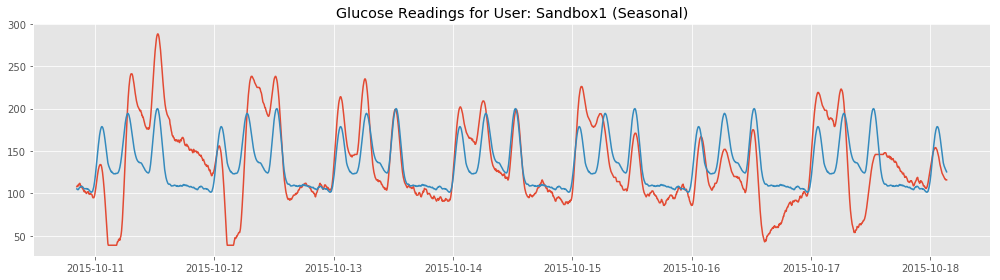

In [256]:
fig, axs = plt.subplots(1, figsize=(14, 4))
plot_seasonal_trend(axs, 'Sandbox1 (Seasonal)', egv_series[6100:8200])
plt.tight_layout()

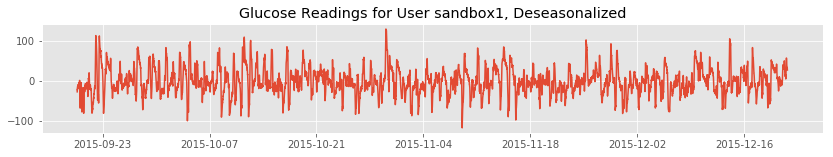

In [124]:
# deseasonalized:
#sandbox4_series = user_results['sandbox4']
sandbox1_seasonal_trend = fit_seasonal_trend(egv_series)
sandbox1_seasonal_detrended = egv_series - sandbox1_seasonal_trend

fig, ax = plt.subplots(1, figsize=(14, 2))
ax.plot(egv_series.index, sandbox1_seasonal_detrended)
ax.set_title("Glucose Readings for User sandbox1, Deseasonalized")

In [ ]:
type(user_results['sandbox4'])

In [125]:
(24 * 60) / 5 #number of daily readings, if every 5 minutes

288

In [130]:
egv_decomposition = sm.tsa.seasonal_decompose(egv_series, freq=288)

In [127]:
def plot_shared_yscales(axs, x, ys, titles):
    ymiddles =  [ (y.max()+y.min())/2 for y in ys ]
    yrange = max( (y.max()-y.min())/2 for y in ys )
    for ax, y, title, ymiddle in zip(axs, ys, titles, ymiddles):
        ax.plot(x, y)
        ax.set_title(title)
        ax.set_ylim((ymiddle-yrange, ymiddle+yrange))
        
def plot_seasonal_decomposition(axs, series, sd):
    plot_shared_yscales(axs,
                        series.index,
                        [series, sd.trend, sd.seasonal, sd.resid],
                        ["Raw Series", "Trend Component $T_t$", "Seasonal Component $S_t$", "Residual Component $R_t$"])

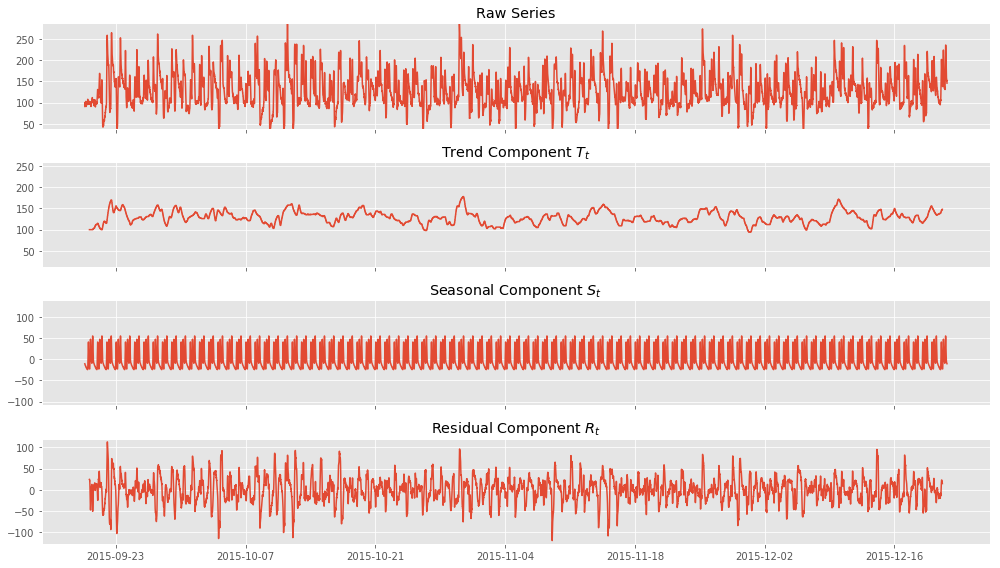

In [128]:
fig, axs = plt.subplots(4, figsize=(14, 8), sharex=True)
plot_seasonal_decomposition(axs, egv_series, egv_decomposition)
plt.tight_layout()

In [ ]:
df_trunc = df.loc['2015-10-04':'2015-10-10']

In [ ]:
df_trunc.shape

In [ ]:
df_trunc.loc[(df_trunc['eventType']=='exercise'), ['eventSubType']]

In [ ]:
df_trunc.loc[(df_trunc['recordType']=='calibration')].head()

In [ ]:
exercisecolors = {'heavy': 'red', 'medium': 'yellow', 'light': 'green'}
for when, howlong, howhard in zip(df_trunc.loc[(df_trunc['eventType']=='exercise'), ['value']].index, df_trunc.loc[(df_trunc['eventType']=='exercise'), ['value']]['value'], df_trunc.loc[(df_trunc['eventType']=='exercise'), ['eventSubType']]['eventSubType']):
    print when, howlong, howhard
    print (when - dt.timedelta(minutes=(howlong * 0.5))), (when + dt.timedelta(minutes=(howlong * 0.5))), exercisecolors[howhard]

In [ ]:
egv_high = 200
egv_low = 80

fig, ax = plt.subplots(figsize=(16,4))
ax.spines['right'].set_visible(False)
#ax.set_frame_on(False)
ax.grid(False)

ax2 = ax.twinx()
ax2.spines['right'].set_visible(False)
ax2.set_frame_on(False)
ax2.grid(False)

ax3 = ax.twinx()
rspine3 = ax3.spines['right']
rspine3.set_position(('axes', 1.05))
ax3.set_frame_on(False)
ax3.patch.set_visible(False)
ax3.grid(False)

ax4 = ax.twinx()
ax4.spines['right'].set_visible(False)
ax4.set_frame_on(False)
ax4.patch.set_visible(False)
ax4.grid(False)

ax5 = ax.twinx()
ax5.spines['right'].set_visible(False)
ax5.set_frame_on(False)
ax5.patch.set_visible(False)
ax5.grid(False)

ax6 = ax.twinx()
ax6.spines['right'].set_visible(False)
ax6.set_frame_on(False)
ax6.patch.set_visible(False)
ax6.grid(False)

fig.subplots_adjust(right=0.85)

ax.plot(df_trunc.loc[(df_trunc['recordType']=='egv'), ['value']].index, df_trunc.loc[(df_trunc['recordType']=='egv'), ['value']], 'black')
ax.set_xlabel('Date')
ax.set_ylabel('EGV / Calibration')

ax2.plot(df_trunc.loc[(df_trunc['eventType']=='insulin'), ['value']].index, df_trunc.loc[(df_trunc['eventType']=='insulin'), ['value']], 'mo')
ax2.set_ylabel('Insulin')

ax3.plot(df_trunc.loc[(df_trunc['eventType']=='carbs'), ['value']].index, df_trunc.loc[(df_trunc['eventType']=='carbs'), ['value']], 'bo')
ax3.set_ylabel('Carbs')

# exercise map
exercisecolors = {'heavy': 'red', 'medium': 'yellow', 'light': 'green'}
for when, howlong, howhard in zip(df_trunc.loc[(df_trunc['eventType']=='exercise'), ['value']].index, df_trunc.loc[(df_trunc['eventType']=='exercise'), ['value']]['value'], df_trunc.loc[(df_trunc['eventType']=='exercise'), ['eventSubType']]['eventSubType']):
    ax4.axvspan((when - dt.timedelta(minutes=(howlong * .5))), (when + dt.timedelta(minutes=(howlong * .5))), facecolor=exercisecolors[howhard], alpha=0.4, zorder=0)
ax4.set_yticks([])

ax5.plot(df_trunc.loc[(df_trunc['recordType']=='calibration'), ['value']].index, df_trunc.loc[(df_trunc['recordType']=='calibration'), ['value']], 'rx', ms=12)
#ax5.set_ylabel('Calibrations')
ax5.set_ylim(ax.get_ylim())
ax5.set_yticks([])

ax6.axhspan(egv_high, ax.get_ylim()[1], facecolor='r', alpha=0.1)
ax6.axhspan(ax.get_ylim()[0], egv_low, facecolor='r', alpha=0.1)
ax6.set_yticks([])
    
ax3.legend([ax.get_lines()[0], ax2.get_lines()[0], ax3.get_lines()[0], ax5.get_lines()[0]], ['EGVs', 'Insulin', 'Carbs', 'Calibrations'], loc=(1.1, 0.5))
ax4.text(1.11, 0.4, "Exercise (Vert. Bars)\nLight=Green\nMedium=Yellow\nHeavy=Red", transform=ax4.transAxes, fontsize=10, verticalalignment='top')
plt.show()

In [ ]:
df2.columns

In [ ]:
df2.loc['2015-10-04':'2015-10-10']

In [ ]:
def __plot_model_2(df, startDay, endDay):
    egv_high = 200
    egv_low = 80
    
    df_trunc = df.loc[startDay:endDay]

    fig, ax = plt.subplots(figsize=(16,4))
    ax.spines['right'].set_visible(False)
    #ax.set_frame_on(False)
    ax.grid(False)

    ax2 = ax.twinx()
    ax2.spines['right'].set_visible(False)
    ax2.set_frame_on(False)
    ax2.grid(False)

    ax3 = ax.twinx()
    rspine3 = ax3.spines['right']
    rspine3.set_position(('axes', 1.05))
    ax3.set_frame_on(False)
    ax3.patch.set_visible(False)
    ax3.grid(False)

    ax4 = ax.twinx()
    ax4.spines['right'].set_visible(False)
    ax4.set_frame_on(False)
    ax4.patch.set_visible(False)
    ax4.grid(False)

    ax5 = ax.twinx()
    ax5.spines['right'].set_visible(False)
    ax5.set_frame_on(False)
    ax5.patch.set_visible(False)
    ax5.grid(False)

    ax6 = ax.twinx()
    ax6.spines['right'].set_visible(False)
    ax6.set_frame_on(False)
    ax6.patch.set_visible(False)
    ax6.grid(False)

    fig.subplots_adjust(right=0.85)

    ax.plot(df_trunc.loc[(df_trunc['recordType_egv']==True), ['value']].index, df_trunc.loc[(df_trunc['recordType_egv']==True), ['value']], 'black')
    ax.set_xlabel('Date')
    ax.set_ylabel('EGV / Calibration')

    ax2.plot(df_trunc.loc[(df_trunc['eventType_insulin']==True), ['value']].index, df_trunc.loc[(df_trunc['eventType_insulin']==True), ['value']], 'mo')
    ax2.set_ylabel('Insulin')

    ax3.plot(df_trunc.loc[(df_trunc['eventType_carbs']==True), ['value']].index, df_trunc.loc[(df_trunc['eventType_carbs']==True), ['value']], 'bo')
    ax3.set_ylabel('Carbs')

    # exercise map
    exercisecolors = {'heavy': 'red', 'medium': 'yellow', 'light': 'green'}
    for when, howlong in zip(df_trunc.loc[(df_trunc['eventType_exercise']==True) & (df_trunc['eventSubType_light']==True), ['value']].index, df_trunc.loc[(df_trunc['eventType_exercise']==True) & (df_trunc['eventSubType_light']==True), ['value']]['value']):
        ax4.axvspan((when - dt.timedelta(minutes=(howlong * .5))), (when + dt.timedelta(minutes=(howlong * .5))), facecolor=exercisecolors['light'], alpha=0.4, zorder=0)
    for when, howlong in zip(df_trunc.loc[(df_trunc['eventType_exercise']==True) & (df_trunc['eventSubType_medium']==True), ['value']].index, df_trunc.loc[(df_trunc['eventType_exercise']==True) & (df_trunc['eventSubType_medium']==True), ['value']]['value']):
        ax4.axvspan((when - dt.timedelta(minutes=(howlong * .5))), (when + dt.timedelta(minutes=(howlong * .5))), facecolor=exercisecolors['medium'], alpha=0.4, zorder=0)
    for when, howlong in zip(df_trunc.loc[(df_trunc['eventType_exercise']==True) & (df_trunc['eventSubType_heavy']==True), ['value']].index, df_trunc.loc[(df_trunc['eventType_exercise']==True) & (df_trunc['eventSubType_heavy']==True), ['value']]['value']):
        ax4.axvspan((when - dt.timedelta(minutes=(howlong * .5))), (when + dt.timedelta(minutes=(howlong * .5))), facecolor=exercisecolors['heavy'], alpha=0.4, zorder=0)
    ax4.set_yticks([])

    ax5.plot(df_trunc.loc[(df_trunc['recordType_calibration']==True), ['value']].index, df_trunc.loc[(df_trunc['recordType_calibration']==True), ['value']], 'rx', ms=12)
    #ax5.set_ylabel('Calibrations')
    ax5.set_ylim(ax.get_ylim())
    ax5.set_yticks([])

    ax6.axhspan(egv_high, ax.get_ylim()[1], facecolor='r', alpha=0.1)
    ax6.axhspan(ax.get_ylim()[0], egv_low, facecolor='r', alpha=0.1)
    ax6.set_yticks([])

    ax3.legend([ax.get_lines()[0], ax2.get_lines()[0], ax3.get_lines()[0], ax5.get_lines()[0]], ['EGVs', 'Insulin', 'Carbs', 'Calibrations'], loc=(1.1, 0.5))
    ax4.text(1.11, 0.4, "Exercise (Vert. Bars)\nLight=Green\nMedium=Yellow\nHeavy=Red", transform=ax4.transAxes, fontsize=10, verticalalignment='top')
    plt.show()

In [47]:

def plot_model(df, startDay, endDay):
    egv_high = 200
    egv_low = 80
    
    df_trunc = df.loc[startDay:endDay]

    fig, ax = plt.subplots(figsize=(16,4))
    ax.spines['right'].set_visible(False)
    #ax.set_frame_on(False)
    ax.grid(False)

    ax2 = ax.twinx()
    ax2.spines['right'].set_visible(False)
    ax2.set_frame_on(False)
    ax2.grid(False)

    ax3 = ax.twinx()
    rspine3 = ax3.spines['right']
    rspine3.set_position(('axes', 1.05))
    ax3.set_frame_on(False)
    ax3.patch.set_visible(False)
    ax3.grid(False)

    ax4 = ax.twinx()
    ax4.spines['right'].set_visible(False)
    ax4.set_frame_on(False)
    ax4.patch.set_visible(False)
    ax4.grid(False)

    ax5 = ax.twinx()
    ax5.spines['right'].set_visible(False)
    ax5.set_frame_on(False)
    ax5.patch.set_visible(False)
    ax5.grid(False)

    ax6 = ax.twinx()
    ax6.spines['right'].set_visible(False)
    ax6.set_frame_on(False)
    ax6.patch.set_visible(False)
    ax6.grid(False)

    fig.subplots_adjust(right=0.85)

    ax.plot(df_trunc.loc[(df_trunc['recordType']=='egv'), ['value']].index, df_trunc.loc[(df_trunc['recordType']=='egv'), ['value']], 'black')
    ax.set_xlabel('Date')
    ax.set_ylabel('EGV / Calibration')

    ax2.plot(df_trunc.loc[(df_trunc['eventType']=='insulin'), ['value']].index, df_trunc.loc[(df_trunc['eventType']=='insulin'), ['value']], 'mo')
    ax2.set_ylabel('Insulin')

    ax3.plot(df_trunc.loc[(df_trunc['eventType']=='carbs'), ['value']].index, df_trunc.loc[(df_trunc['eventType']=='carbs'), ['value']], 'bo')
    ax3.set_ylabel('Carbs')

    # exercise map
    exercisecolors = {'heavy': 'red', 'medium': 'yellow', 'light': 'green'}
    for when, howlong, howhard in zip(df_trunc.loc[(df_trunc['eventType']=='exercise'), ['value']].index, df_trunc.loc[(df_trunc['eventType']=='exercise'), ['value']]['value'], df_trunc.loc[(df_trunc['eventType']=='exercise'), ['eventSubType']]['eventSubType']):
        ax4.axvspan((when - dt.timedelta(minutes=(howlong * .5))), (when + dt.timedelta(minutes=(howlong * .5))), facecolor=exercisecolors[howhard], alpha=0.4, zorder=0)
    ax4.set_yticks([])

    ax5.plot(df_trunc.loc[(df_trunc['recordType']=='calibration'), ['value']].index, df_trunc.loc[(df_trunc['recordType']=='calibration'), ['value']], 'rx', ms=12)
    #ax5.set_ylabel('Calibrations')
    ax5.set_ylim(ax.get_ylim())
    ax5.set_yticks([])

    ax6.axhspan(egv_high, ax.get_ylim()[1], facecolor='r', alpha=0.1)
    ax6.axhspan(ax.get_ylim()[0], egv_low, facecolor='r', alpha=0.1)
    ax6.set_yticks([])

    ax3.legend([ax.get_lines()[0], ax5.get_lines()[0], ax3.get_lines()[0], ax2.get_lines()[0]], ['EGVs', 'Calibrations', 'Carbs', 'Insulin'], loc=(1.1, 0.5))
    ax4.text(1.11, 0.4, "Exercise (Vert. Bars)\nLight=Green\nMedium=Yellow\nHeavy=Red", transform=ax4.transAxes, fontsize=10, verticalalignment='top')
    plt.show()

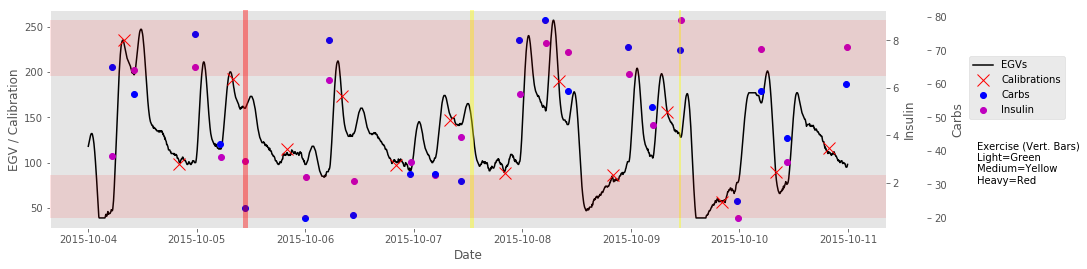

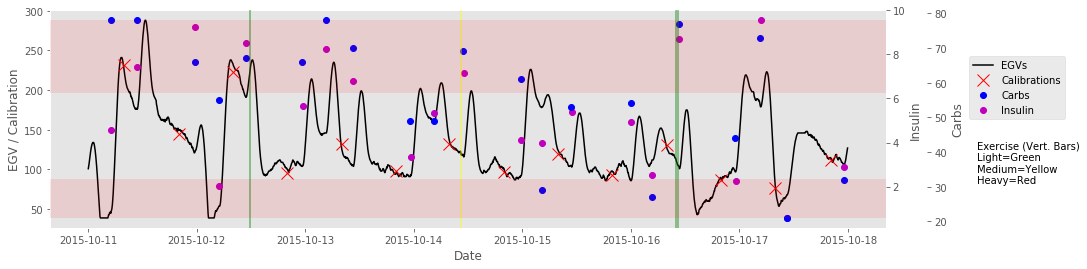

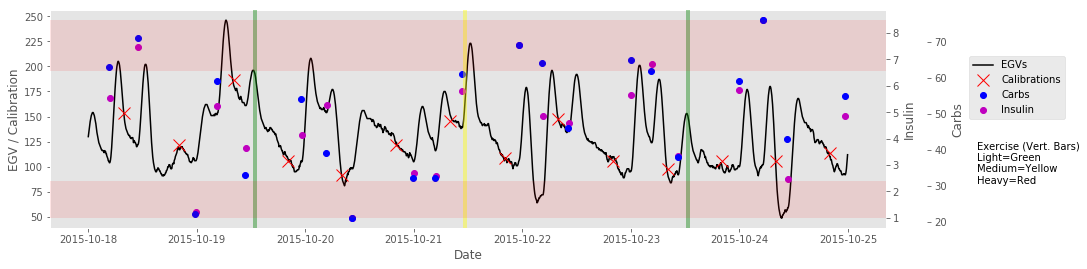

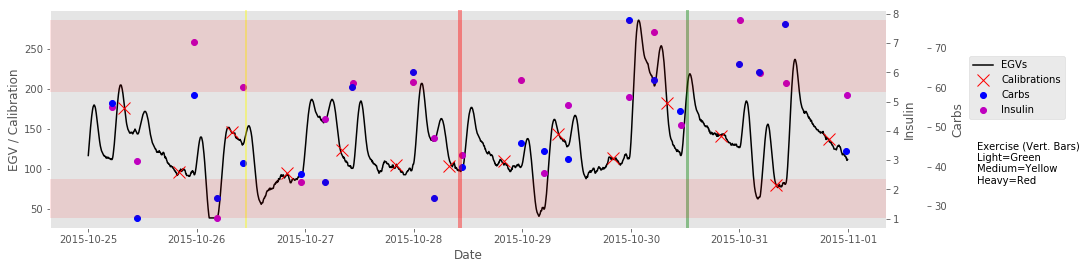

In [48]:
plot_model(df, '10-04-2015', '10-10-2015')
plot_model(df, '10-11-2015', '10-17-2015')
plot_model(df, '10-18-2015', '10-24-2015')
plot_model(df, '10-25-2015', '10-31-2015')

In [ ]:
# plot EGVs only
def plot_incr_model1(df, startDay, endDay):
    
    df_trunc = df.loc[startDay:endDay]

    fig, ax = plt.subplots(figsize=(16,4))
    ax.spines['right'].set_visible(False)
    #ax.set_frame_on(False)
    ax.grid(False)

    ax.plot(df_trunc.loc[(df_trunc['recordType']=='egv'), ['value']].index, df_trunc.loc[(df_trunc['recordType']=='egv'), ['value']], 'black')
    ax.set_xlabel('Date')
    ax.set_ylabel('EGV')

    ax.legend([ax.get_lines()[0]], ['EGVs'], loc=(1.1, 0.5))
    
    plt.show()

In [ ]:
plot_incr_model1(df, '10-04-2015', '10-10-2015')

In [ ]:
# add danger zone
def plot_incr_model2(df, startDay, endDay):
    egv_high = 200
    egv_low = 80
    
    df_trunc = df.loc[startDay:endDay]

    fig, ax = plt.subplots(figsize=(16,4))
    ax.spines['right'].set_visible(False)
    #ax.set_frame_on(False)
    ax.grid(False)

    ax6 = ax.twinx()
    ax6.spines['right'].set_visible(False)
    ax6.set_frame_on(False)
    ax6.patch.set_visible(False)
    ax6.grid(False)

    fig.subplots_adjust(right=0.85)

    ax.plot(df_trunc.loc[(df_trunc['recordType']=='egv'), ['value']].index, df_trunc.loc[(df_trunc['recordType']=='egv'), ['value']], 'black')
    ax.set_xlabel('Date')
    ax.set_ylabel('EGV')

    ax6.axhspan(egv_high, ax.get_ylim()[1], facecolor='r', alpha=0.1)
    ax6.axhspan(ax.get_ylim()[0], egv_low, facecolor='r', alpha=0.1)
    ax6.set_yticks([])

    ax.legend([ax.get_lines()[0]], ['EGVs'], loc=(1.1, 0.5))
    plt.show()

In [ ]:
plot_incr_model2(df, '10-04-2015', '10-10-2015')

In [ ]:
# add calibrations
def plot_incr_model3(df, startDay, endDay):
    egv_high = 200
    egv_low = 80
    
    df_trunc = df.loc[startDay:endDay]

    fig, ax = plt.subplots(figsize=(16,4))
    ax.spines['right'].set_visible(False)
    #ax.set_frame_on(False)
    ax.grid(False)

    ax5 = ax.twinx()
    ax5.spines['right'].set_visible(False)
    ax5.set_frame_on(False)
    ax5.patch.set_visible(False)
    ax5.grid(False)

    ax6 = ax.twinx()
    ax6.spines['right'].set_visible(False)
    ax6.set_frame_on(False)
    ax6.patch.set_visible(False)
    ax6.grid(False)

    fig.subplots_adjust(right=0.85)

    ax.plot(df_trunc.loc[(df_trunc['recordType']=='egv'), ['value']].index, df_trunc.loc[(df_trunc['recordType']=='egv'), ['value']], 'black')
    ax.set_xlabel('Date')
    ax.set_ylabel('EGV / Calibration')

    ax5.plot(df_trunc.loc[(df_trunc['recordType']=='calibration'), ['value']].index, df_trunc.loc[(df_trunc['recordType']=='calibration'), ['value']], 'rx', ms=12)
    #ax5.set_ylabel('Calibrations')
    ax5.set_ylim(ax.get_ylim())
    ax5.set_yticks([])

    ax6.axhspan(egv_high, ax.get_ylim()[1], facecolor='r', alpha=0.1)
    ax6.axhspan(ax.get_ylim()[0], egv_low, facecolor='r', alpha=0.1)
    ax6.set_yticks([])

    ax.legend([ax.get_lines()[0], ax5.get_lines()[0]], ['EGVs', 'Calibrations'], loc=(1.1, 0.5))
    plt.show()

In [ ]:
plot_incr_model3(df, '10-04-2015', '10-10-2015')

In [ ]:
# add carbs
def plot_incr_model4(df, startDay, endDay):
    egv_high = 200
    egv_low = 80
    
    df_trunc = df.loc[startDay:endDay]

    fig, ax = plt.subplots(figsize=(16,4))
    ax.spines['right'].set_visible(False)
    #ax.set_frame_on(False)
    ax.grid(False)

    ax3 = ax.twinx()
    rspine3 = ax3.spines['right']
    rspine3.set_position(('axes', 1.05))
    ax3.set_frame_on(False)
    ax3.patch.set_visible(False)
    ax3.grid(False)

    ax5 = ax.twinx()
    ax5.spines['right'].set_visible(False)
    ax5.set_frame_on(False)
    ax5.patch.set_visible(False)
    ax5.grid(False)

    ax6 = ax.twinx()
    ax6.spines['right'].set_visible(False)
    ax6.set_frame_on(False)
    ax6.patch.set_visible(False)
    ax6.grid(False)

    fig.subplots_adjust(right=0.85)

    ax.plot(df_trunc.loc[(df_trunc['recordType']=='egv'), ['value']].index, df_trunc.loc[(df_trunc['recordType']=='egv'), ['value']], 'black')
    ax.set_xlabel('Date')
    ax.set_ylabel('EGV / Calibration')

    ax3.plot(df_trunc.loc[(df_trunc['eventType']=='carbs'), ['value']].index, df_trunc.loc[(df_trunc['eventType']=='carbs'), ['value']], 'bo')
    ax3.set_ylabel('Carbs')

    ax5.plot(df_trunc.loc[(df_trunc['recordType']=='calibration'), ['value']].index, df_trunc.loc[(df_trunc['recordType']=='calibration'), ['value']], 'rx', ms=12)
    #ax5.set_ylabel('Calibrations')
    ax5.set_ylim(ax.get_ylim())
    ax5.set_yticks([])

    ax6.axhspan(egv_high, ax.get_ylim()[1], facecolor='r', alpha=0.1)
    ax6.axhspan(ax.get_ylim()[0], egv_low, facecolor='r', alpha=0.1)
    ax6.set_yticks([])

    ax3.legend([ax.get_lines()[0], ax5.get_lines()[0], ax3.get_lines()[0]], ['EGVs', 'Calibrations', 'Carbs'], loc=(1.1, 0.5))
    plt.show()

In [ ]:
plot_incr_model4(df, '10-04-2015', '10-10-2015')

In [ ]:
# add insulin
def plot_incr_model5(df, startDay, endDay):
    egv_high = 200
    egv_low = 80
    
    df_trunc = df.loc[startDay:endDay]

    fig, ax = plt.subplots(figsize=(16,4))
    ax.spines['right'].set_visible(False)
    #ax.set_frame_on(False)
    ax.grid(False)

    ax2 = ax.twinx()
    ax2.spines['right'].set_visible(False)
    ax2.set_frame_on(False)
    ax2.grid(False)

    ax3 = ax.twinx()
    rspine3 = ax3.spines['right']
    rspine3.set_position(('axes', 1.05))
    ax3.set_frame_on(False)
    ax3.patch.set_visible(False)
    ax3.grid(False)

    ax5 = ax.twinx()
    ax5.spines['right'].set_visible(False)
    ax5.set_frame_on(False)
    ax5.patch.set_visible(False)
    ax5.grid(False)

    ax6 = ax.twinx()
    ax6.spines['right'].set_visible(False)
    ax6.set_frame_on(False)
    ax6.patch.set_visible(False)
    ax6.grid(False)

    fig.subplots_adjust(right=0.85)

    ax.plot(df_trunc.loc[(df_trunc['recordType']=='egv'), ['value']].index, df_trunc.loc[(df_trunc['recordType']=='egv'), ['value']], 'black')
    ax.set_xlabel('Date')
    ax.set_ylabel('EGV / Calibration')

    ax2.plot(df_trunc.loc[(df_trunc['eventType']=='insulin'), ['value']].index, df_trunc.loc[(df_trunc['eventType']=='insulin'), ['value']], 'mo')
    ax2.set_ylabel('Insulin')

    ax3.plot(df_trunc.loc[(df_trunc['eventType']=='carbs'), ['value']].index, df_trunc.loc[(df_trunc['eventType']=='carbs'), ['value']], 'bo')
    ax3.set_ylabel('Carbs')

    ax5.plot(df_trunc.loc[(df_trunc['recordType']=='calibration'), ['value']].index, df_trunc.loc[(df_trunc['recordType']=='calibration'), ['value']], 'rx', ms=12)
    #ax5.set_ylabel('Calibrations')
    ax5.set_ylim(ax.get_ylim())
    ax5.set_yticks([])

    ax6.axhspan(egv_high, ax.get_ylim()[1], facecolor='r', alpha=0.1)
    ax6.axhspan(ax.get_ylim()[0], egv_low, facecolor='r', alpha=0.1)
    ax6.set_yticks([])

    ax3.legend([ax.get_lines()[0], ax5.get_lines()[0], ax3.get_lines()[0], ax2.get_lines()[0]], ['EGVs', 'Calibrations', 'Carbs', 'Insulin'], loc=(1.1, 0.5))
    plt.show()

In [ ]:
plot_incr_model5(df, '10-04-2015', '10-10-2015')

In [ ]:
# add exercise
def plot_incr_model6(df, startDay, endDay):
    egv_high = 200
    egv_low = 80
    
    df_trunc = df.loc[startDay:endDay]

    fig, ax = plt.subplots(figsize=(16,4))
    ax.spines['right'].set_visible(False)
    #ax.set_frame_on(False)
    ax.grid(False)

    ax2 = ax.twinx()
    ax2.spines['right'].set_visible(False)
    ax2.set_frame_on(False)
    ax2.grid(False)

    ax3 = ax.twinx()
    rspine3 = ax3.spines['right']
    rspine3.set_position(('axes', 1.05))
    ax3.set_frame_on(False)
    ax3.patch.set_visible(False)
    ax3.grid(False)

    ax4 = ax.twinx()
    ax4.spines['right'].set_visible(False)
    ax4.set_frame_on(False)
    ax4.patch.set_visible(False)
    ax4.grid(False)

    ax5 = ax.twinx()
    ax5.spines['right'].set_visible(False)
    ax5.set_frame_on(False)
    ax5.patch.set_visible(False)
    ax5.grid(False)

    ax6 = ax.twinx()
    ax6.spines['right'].set_visible(False)
    ax6.set_frame_on(False)
    ax6.patch.set_visible(False)
    ax6.grid(False)

    fig.subplots_adjust(right=0.85)

    ax.plot(df_trunc.loc[(df_trunc['recordType']=='egv'), ['value']].index, df_trunc.loc[(df_trunc['recordType']=='egv'), ['value']], 'black')
    ax.set_xlabel('Date')
    ax.set_ylabel('EGV / Calibration')

    ax2.plot(df_trunc.loc[(df_trunc['eventType']=='insulin'), ['value']].index, df_trunc.loc[(df_trunc['eventType']=='insulin'), ['value']], 'mo')
    ax2.set_ylabel('Insulin')

    ax3.plot(df_trunc.loc[(df_trunc['eventType']=='carbs'), ['value']].index, df_trunc.loc[(df_trunc['eventType']=='carbs'), ['value']], 'bo')
    ax3.set_ylabel('Carbs')

    # exercise map
    exercisecolors = {'heavy': 'red', 'medium': 'yellow', 'light': 'green'}
    for when, howlong, howhard in zip(df_trunc.loc[(df_trunc['eventType']=='exercise'), ['value']].index, df_trunc.loc[(df_trunc['eventType']=='exercise'), ['value']]['value'], df_trunc.loc[(df_trunc['eventType']=='exercise'), ['eventSubType']]['eventSubType']):
        ax4.axvspan((when - dt.timedelta(minutes=(howlong * .5))), (when + dt.timedelta(minutes=(howlong * .5))), facecolor=exercisecolors[howhard], alpha=0.4, zorder=0)
    ax4.set_yticks([])

    ax5.plot(df_trunc.loc[(df_trunc['recordType']=='calibration'), ['value']].index, df_trunc.loc[(df_trunc['recordType']=='calibration'), ['value']], 'rx', ms=12)
    #ax5.set_ylabel('Calibrations')
    ax5.set_ylim(ax.get_ylim())
    ax5.set_yticks([])

    ax6.axhspan(egv_high, ax.get_ylim()[1], facecolor='r', alpha=0.1)
    ax6.axhspan(ax.get_ylim()[0], egv_low, facecolor='r', alpha=0.1)
    ax6.set_yticks([])

    ax3.legend([ax.get_lines()[0], ax5.get_lines()[0], ax3.get_lines()[0], ax2.get_lines()[0]], ['EGVs', 'Calibrations', 'Carbs', 'Insulin'], loc=(1.1, 0.5))
    ax4.text(1.11, 0.4, "Exercise (Vert. Bars)\nLight=Green\nMedium=Yellow\nHeavy=Red", transform=ax4.transAxes, fontsize=10, verticalalignment='top')
    plt.show()

In [ ]:
plot_incr_model6(df, '10-04-2015', '10-10-2015')

In [ ]:
# add other events
def plot_incr_model7(df, startDay, endDay):
    egv_high = 200
    egv_low = 80
    
    df_trunc = df.loc[startDay:endDay]

    fig, ax = plt.subplots(figsize=(16,4))
    ax.spines['right'].set_visible(False)
    #ax.set_frame_on(False)
    ax.grid(False)

    ax2 = ax.twinx()
    ax2.spines['right'].set_visible(False)
    ax2.set_frame_on(False)
    ax2.grid(False)

    ax3 = ax.twinx()
    rspine3 = ax3.spines['right']
    rspine3.set_position(('axes', 1.05))
    ax3.set_frame_on(False)
    ax3.patch.set_visible(False)
    ax3.grid(False)

    ax4 = ax.twinx()
    ax4.spines['right'].set_visible(False)
    ax4.set_frame_on(False)
    ax4.patch.set_visible(False)
    ax4.grid(False)

    ax5 = ax.twinx()
    ax5.spines['right'].set_visible(False)
    ax5.set_frame_on(False)
    ax5.patch.set_visible(False)
    ax5.grid(False)

    ax6 = ax.twinx()
    ax6.spines['right'].set_visible(False)
    ax6.set_frame_on(False)
    ax6.patch.set_visible(False)
    ax6.grid(False)
    
    ax7 = ax.twinx()
    ax7.spines['right'].set_visible(False)
    ax7.set_frame_on(False)
    ax7.patch.set_visible(False)
    ax7.grid(False)

    fig.subplots_adjust(right=0.85)

    ax.plot(df_trunc.loc[(df_trunc['recordType']=='egv'), ['value']].index, df_trunc.loc[(df_trunc['recordType']=='egv'), ['value']], 'black')
    ax.set_xlabel('Date')
    ax.set_ylabel('EGV / Calibration')

    ax2.plot(df_trunc.loc[(df_trunc['eventType']=='insulin'), ['value']].index, df_trunc.loc[(df_trunc['eventType']=='insulin'), ['value']], 'mo')
    ax2.set_ylabel('Insulin')

    ax3.plot(df_trunc.loc[(df_trunc['eventType']=='carbs'), ['value']].index, df_trunc.loc[(df_trunc['eventType']=='carbs'), ['value']], 'bo')
    ax3.set_ylabel('Carbs')

    # exercise map
    exercisecolors = {'heavy': 'red', 'medium': 'yellow', 'light': 'green'}
    for when, howlong, howhard in zip(df_trunc.loc[(df_trunc['eventType']=='exercise'), ['value']].index, df_trunc.loc[(df_trunc['eventType']=='exercise'), ['value']]['value'], df_trunc.loc[(df_trunc['eventType']=='exercise'), ['eventSubType']]['eventSubType']):
        ax4.axvspan((when - dt.timedelta(minutes=(howlong * .5))), (when + dt.timedelta(minutes=(howlong * .5))), facecolor=exercisecolors[howhard], alpha=0.4, zorder=0)
    ax4.set_yticks([])

    ax5.plot(df_trunc.loc[(df_trunc['recordType']=='calibration'), ['value']].index, df_trunc.loc[(df_trunc['recordType']=='calibration'), ['value']], 'rx', ms=12)
    #ax5.set_ylabel('Calibrations')
    ax5.set_ylim(ax.get_ylim())
    ax5.set_yticks([])

    ax6.axhspan(egv_high, ax.get_ylim()[1], facecolor='r', alpha=0.1)
    ax6.axhspan(ax.get_ylim()[0], egv_low, facecolor='r', alpha=0.1)
    ax6.set_yticks([])
    
    ax7yvals = []
    for i in range(len(df_trunc.loc[(df_trunc['eventType']=='health', ['eventSubType'])])):
        ax7yvals.append(int(ax.get_ylim()[0]+25+i))
    ax7.plot(df_trunc.loc[(df_trunc['eventType']=='health'), ['value']].index, ax7yvals, 'gD')
    ax7.set_ylabel('Events')
    ax7.set_yticks([])

    ax3.legend([ax.get_lines()[0], ax2.get_lines()[0], ax3.get_lines()[0], ax5.get_lines()[0], ax7.get_lines()[0]], ['EGVs', 'Calibrations', 'Carbs', 'Insulin'], loc=(1.1, 0.5))
    ax4.text(1.11, 0.4, "Exercise (Vert. Bars)\nLight=Green\nMedium=Yellow\nHeavy=Red", transform=ax4.transAxes, fontsize=10, verticalalignment='top')
    plt.show()

In [ ]:
yvals = []
for i in range(len(df_trunc.loc[(df_trunc['eventType']=='health', ['eventSubType'])])):
    yvals.append(int(ax.get_ylim()[0]+25))
yvals

In [ ]:
df_trunc.loc[(df_trunc['eventType']=='health', ['value'])]

In [ ]:
plot_incr_model7(df, '10-04-2015', '10-10-2015')

In [ ]:
# show how each data point calculates relationship to all prior event types

In [50]:
from sklearn.linear_model import LogisticRegressionCV

In [55]:
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant

In [ ]:
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [51]:
type(df5['value'])

pandas.core.series.Series

In [49]:
def plot_series_and_difference(axs, series, title):
    diff = series.diff()
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series: {}".format(title))
    axs[1].plot(series.index, diff)
    axs[1].set_title("Series of First Differences: {}".format(title))

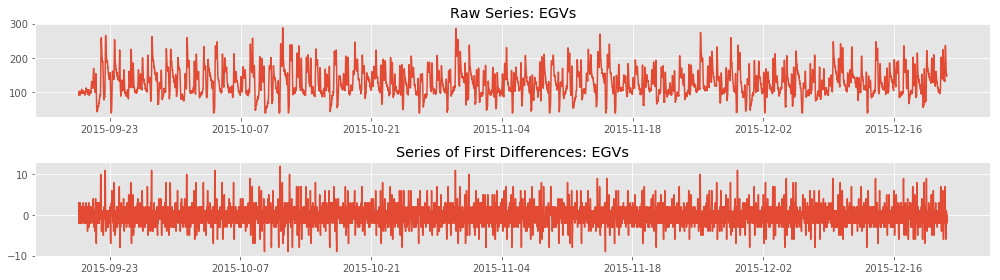

In [62]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_series_and_difference(axs, df5['value'], 'EGVs')
fig.tight_layout()

In [141]:
df5.value.diff().unique()

array([ nan,   2.,   1.,  -2.,   0.,   3.,  -1.,  -4.,  -3.,   4.,  -5.,
        -6.,  -7.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  -8.,  -9.,
        12.])

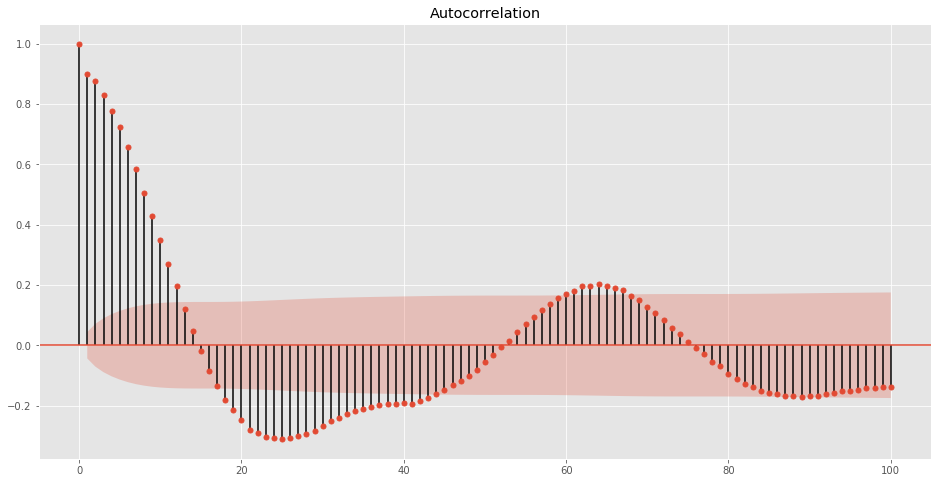

In [137]:
fig, ax = plt.subplots(1, figsize=(16, 8))

_ = sm.graphics.tsa.plot_acf(df5['value'].diff()[1:2000], lags=100, ax=ax) #need to set lags=____ here?

In [106]:
egv_series = df5['value']

#egv_model = SARIMAX(egv_series, order=(9, 1, 0), seasonal_order=(1, 0, 0, 24)).fit()
egv_model = SARIMAX(egv_series, order=(2, 1, 0)).fit()

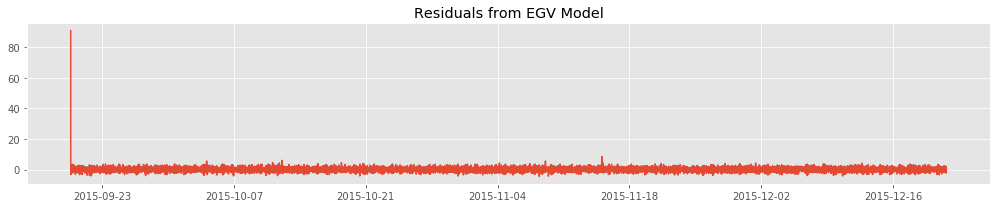

In [107]:
fig, ax = plt.subplots(1, figsize=(14, 3))
ax.plot(egv_model.resid.index, egv_model.resid)
ax.set_title("Residuals from EGV Model")
plt.tight_layout()

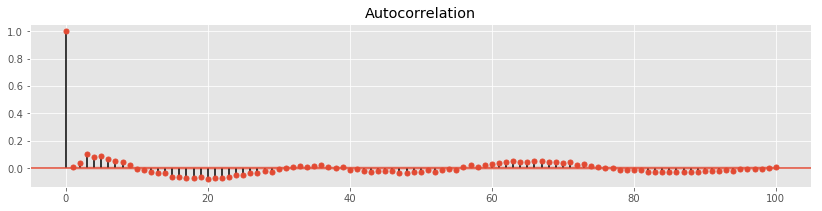

In [108]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(egv_model.resid, lags=100, ax=ax)

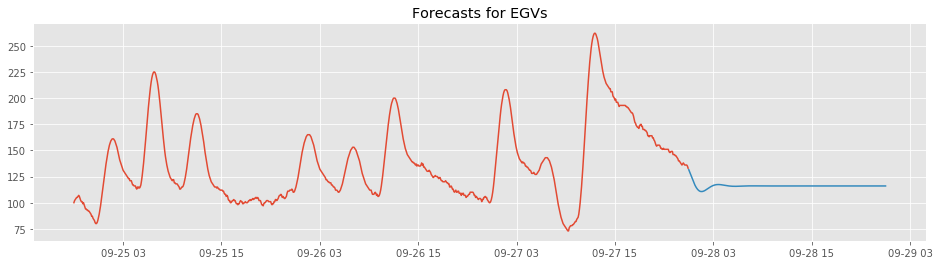

In [105]:
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(egv_series[1500:2400].index, egv_series[1500:2400])

preds = egv_model.predict('2015-09-28', '2015-09-29', 
                   dynamic=True, ax=ax, plot_insample=False)

ax.plot(preds.index, preds)
ax.set_title("Forecasts for EGVs")

In [94]:
egv_model.score()

AttributeError: 'SARIMAXResults' object has no attribute 'score'

In [56]:
df5.columns

Index([                     u'status',                       u'trend',
                         u'trendRate',                        u'user',
                             u'value',                  u'dangerZone',
              u'last_calib_timedelta',         u'last_calib_accuracy',
            u'last_insulin_timedelta',            u'last_insulin_amt',
              u'last_carbs_timedelta',              u'last_carbs_amt',
           u'last_exercise_timedelta',           u'last_exercise_amt',
                u'last_exercise_type',       u'last_stress_timedelta',
       u'last_highSymptoms_timedelta',  u'last_lowSymptoms_timedelta',
            u'last_illness_timedelta',      u'last_alcohol_timedelta'],
      dtype='object')

In [ ]:
df5.drop('dangerZone').values

In [ ]:
X = df5.drop('dangerZone').values
y = df5['dangerZone'].values

In [ ]:
kfold = KFold(len(y))

accuracies = []
precisions = []
recalls = []

for train_index, test_index in kfold:
    model = LogisticRegression()
    model.fit(X[train_index], y[train_index])
    y_predict = model.predict(X[test_index])
    y_true = y[test_index]
    accuracies.append(accuracy_score(y_true, y_predict))
    precisions.append(precision_score(y_true, y_predict))
    recalls.append(recall_score(y_true, y_predict))

print "accuracy:", np.average(accuracies)
print "precision:", np.average(precisions)
print "recall:", np.average(recalls)

In [144]:
df10 = df5.copy()

In [145]:
df10.tail()

,status,trend,trendRate,user,value,dangerZone,last_calib_timedelta,last_calib_accuracy,last_insulin_timedelta,last_insulin_amt,last_carbs_timedelta,last_carbs_amt,last_exercise_timedelta,last_exercise_amt,last_exercise_type,last_stress_timedelta,last_highSymptoms_timedelta,last_lowSymptoms_timedelta,last_illness_timedelta,last_alcohol_timedelta
displayTime,,,,,,,,,,,,,,,,,,,,
2015-12-21 15:35:00,normal,flat,-0.4,sandbox1,149,False,26953.0,0.98,17460.0,6.33,17820.0,70.0,9540.0,17.0,medium,25320.0,11100.0,24360.0,NaN,NaN
2015-12-21 15:40:00,normal,flat,-0.2,sandbox1,149,False,27253.0,0.98,17760.0,6.33,18120.0,70.0,9840.0,17.0,medium,25620.0,11400.0,24660.0,NaN,NaN
2015-12-21 15:45:00,normal,flat,-0.1,sandbox1,148,False,27553.0,0.98,18060.0,6.33,18420.0,70.0,10140.0,17.0,medium,25920.0,11700.0,24960.0,NaN,NaN
2015-12-21 15:50:00,normal,flat,-0.1,sandbox1,148,False,27853.0,0.98,18360.0,6.33,18720.0,70.0,10440.0,17.0,medium,26220.0,12000.0,25260.0,NaN,NaN
2015-12-21 15:55:00,normal,flat,-0.2,sandbox1,146,False,28153.0,0.98,18660.0,6.33,19020.0,70.0,10740.0,17.0,medium,26520.0,12300.0,25560.0,NaN,NaN


In [147]:
df10.drop(['dangerZone', 'trend', 'user', 'status'], inplace=True, axis=1)

In [152]:
df10 = pd.get_dummies(df10)

In [174]:
df10cols = df10.columns.tolist()

In [178]:
cols = df10cols[1:]
cols.append(df10cols[0])
cols

[u'value',
 'last_calib_timedelta',
 'last_calib_accuracy',
 'last_insulin_timedelta',
 'last_insulin_amt',
 'last_carbs_timedelta',
 'last_carbs_amt',
 'last_exercise_timedelta',
 'last_exercise_amt',
 'last_stress_timedelta',
 'last_highSymptoms_timedelta',
 'last_lowSymptoms_timedelta',
 'last_illness_timedelta',
 'last_alcohol_timedelta',
 u'last_exercise_type_heavy',
 u'last_exercise_type_light',
 u'last_exercise_type_medium',
 u'trendRate']

In [179]:
df11 = df10[cols]

In [180]:
df11.tail()

,value,last_calib_timedelta,last_calib_accuracy,last_insulin_timedelta,last_insulin_amt,last_carbs_timedelta,last_carbs_amt,last_exercise_timedelta,last_exercise_amt,last_stress_timedelta,last_highSymptoms_timedelta,last_lowSymptoms_timedelta,last_illness_timedelta,last_alcohol_timedelta,last_exercise_type_heavy,last_exercise_type_light,last_exercise_type_medium,trendRate
displayTime,,,,,,,,,,,,,,,,,,
2015-12-21 15:35:00,149,26953.0,0.98,17460.0,6.33,17820.0,70.0,9540.0,17.0,25320.0,11100.0,24360.0,NaN,NaN,0,0,1,-0.4
2015-12-21 15:40:00,149,27253.0,0.98,17760.0,6.33,18120.0,70.0,9840.0,17.0,25620.0,11400.0,24660.0,NaN,NaN,0,0,1,-0.2
2015-12-21 15:45:00,148,27553.0,0.98,18060.0,6.33,18420.0,70.0,10140.0,17.0,25920.0,11700.0,24960.0,NaN,NaN,0,0,1,-0.1
2015-12-21 15:50:00,148,27853.0,0.98,18360.0,6.33,18720.0,70.0,10440.0,17.0,26220.0,12000.0,25260.0,NaN,NaN,0,0,1,-0.1
2015-12-21 15:55:00,146,28153.0,0.98,18660.0,6.33,19020.0,70.0,10740.0,17.0,26520.0,12300.0,25560.0,NaN,NaN,0,0,1,-0.2


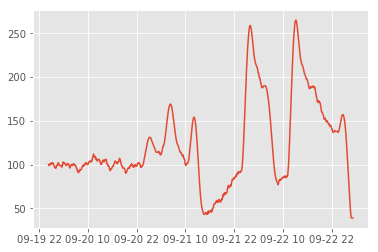

In [192]:
plt.plot(df11['value'][100:1000])

In [264]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.fillna(0, inplace=True)
	return agg

# load dataset
dataset = df11
values = dataset.values
# integer encode direction
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
values = np.nan_to_num(values)
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag readings
n_readings = 100
n_features = 18
# frame as supervised learning
reframed = series_to_supervised(scaled, n_readings, 1)


In [ ]:
# split into train and test sets
values = reframed.values
n_train_readings = 288*60
train = values[:n_train_readings, :]
test = values[n_train_readings:, :]
# split into input and outputs
n_obs = n_readings * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_readings, n_features))
test_X = test_X.reshape((test_X.shape[0], n_readings, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_readings*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -17:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -17:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)



((17280, 1800), 17280, (17280,))
((17280, 100, 18), (17280,), (9504, 100, 18), (9504,))
Train on 17280 samples, validate on 9504 samples
Epoch 1/50
52s - loss: 0.1232 - val_loss: 0.1075
Epoch 2/50
50s - loss: 0.0670 - val_loss: 0.0502
Epoch 3/50
51s - loss: 0.0571 - val_loss: 0.0403
Epoch 4/50
393s - loss: 0.0315 - val_loss: 0.0645
Epoch 5/50
56s - loss: 0.0390 - val_loss: 0.0769
Epoch 6/50
50s - loss: 0.0348 - val_loss: 0.1165
Epoch 7/50
51s - loss: 0.0357 - val_loss: 0.0285
Epoch 8/50
49s - loss: 0.0296 - val_loss: 0.0273
Epoch 9/50
50s - loss: 0.0184 - val_loss: 0.0334
Epoch 10/50


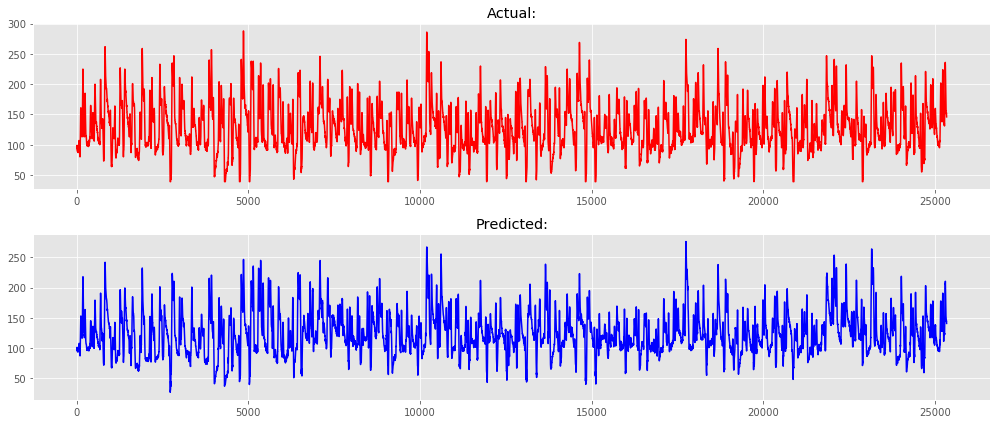

In [261]:
fig, axs = plt.subplots(2, figsize=(14,6))
axs[0].plot(inv_y, 'r')
axs[0].set_title("Actual:")
axs[1].plot(inv_yhat, 'b')
axs[1].set_title("Predicted:")
plt.tight_layout()

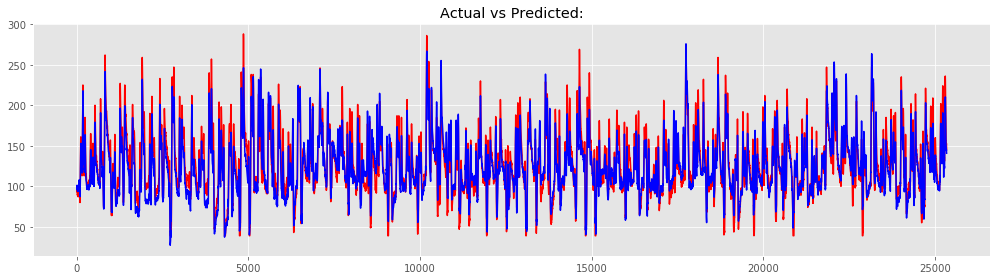

In [262]:
fig, axs = plt.subplots(1, figsize=(14,4))
axs.plot(inv_y, 'r')
axs.plot(inv_yhat, 'b')
axs.set_title("Actual vs Predicted:")
plt.tight_layout()

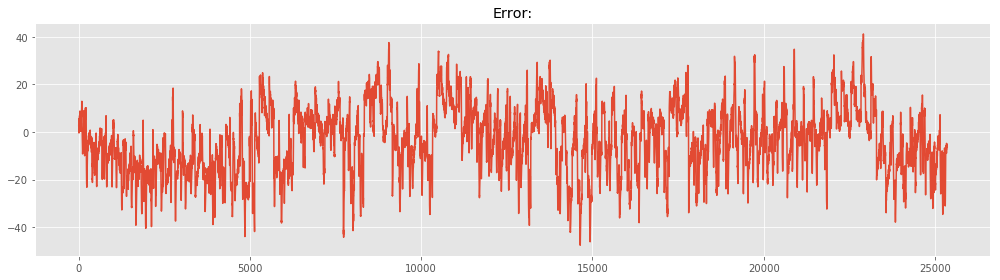

In [263]:
fig, axs = plt.subplots(1, figsize=(14,4))
axs.plot(inv_yhat - inv_y)
axs.set_title("Error:")
plt.tight_layout()

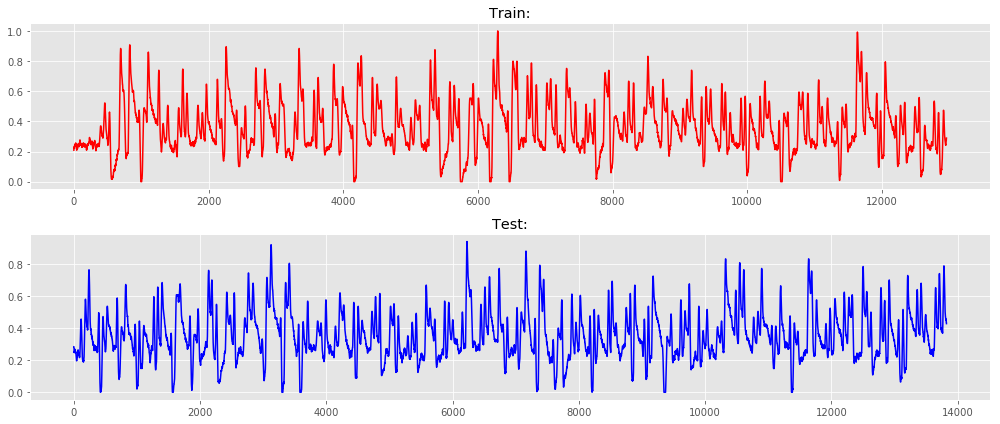

In [235]:
fig, axs = plt.subplots(2, figsize=(14,6))
axs[0].plot(train_y, 'r')
axs[0].set_title("Train:")
axs[1].plot(test_y, 'b')
axs[1].set_title("Test:")
plt.tight_layout()

In [228]:
train[:100, -17]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.00562435,  0.01242799,
        0.01923164,  0.02603529,  0.03283894,  0.03964258,  0.04644623,
        0.05324988,  0.06005352,  0.06685717,  0.07366082,  0.08046447,
        0.08726811,  0.09407176,  0.10087541,  0.10767905,  0.1144827 ,
        0.12128635,  0.12808999,  0.13489364,  0.14169729,  0.14